## Introdução

O Sistema de Informações Hospitalares do Sistema Único de Saúde (SIH/SUS) constitui uma das principais bases administrativas de saúde do Brasil, reunindo registros de internações hospitalares financiadas pelo SUS em todo o território nacional. Essas informações são fundamentais para o monitoramento da morbidade hospitalar, da utilização dos serviços de saúde e para o apoio à formulação de políticas públicas baseadas em evidências.

O conjunto de dados **SIH/SUS – Admissões Hospitalares por Municípios (2024)**, disponibilizado no Kaggle, permite a análise das internações ocorridas ao longo do ano de 2024, com foco no nível municipal. A natureza quantitativa dessas informações possibilita a aplicação de métodos estatísticos apropriados para dados de contagem, com destaque para os Modelos Lineares Generalizados.


## O Banco de Dados

O banco de dados é derivado do **SIH/SUS**, cujas informações são coletadas por meio das **Autorizações de Internação Hospitalar (AIH)**. Cada AIH corresponde a uma internação e contém dados clínicos, demográficos e administrativos relacionados ao atendimento hospitalar.

Neste dataset, os registros foram agregados por município, contemplando variáveis como número de internações, óbitos hospitalares, dias de permanência, utilização de UTI e características institucionais das unidades de saúde. Essa estrutura permite comparações espaciais entre municípios e regiões, além da investigação de padrões de utilização dos serviços hospitalares do SUS.


## Modelagem Estatística (GLM)

A variável resposta principal — número de admissões hospitalares — é caracterizada como **dado de contagem**, assumindo valores inteiros não negativos. Nesse contexto, a análise é conduzida por meio de **Modelos Lineares Generalizados (GLM)**, que permitem modelar a relação entre a variável resposta e um conjunto de covariáveis explicativas.

Inicialmente, pode-se empregar a distribuição **Poisson**, adequada para modelagem de contagens sob a suposição de igualdade entre média e variância. Contudo, devido à heterogeneidade regional e à variabilidade observada nos dados de saúde, é comum a ocorrência de **sobredispersão**, tornando a **Binomial Negativa** uma alternativa mais apropriada. Essas abordagens possibilitam a identificação de fatores associados às admissões hospitalares e a avaliação de diferenças entre municípios.


In [9]:
import kagglehub

# Download latest version
#path = kagglehub.dataset_download("andersonfranca/sistema-de-informaes-hospitalares-sus")
import pandas as pd

#df = pd.read_csv(
 #   "RD202412.csv",
   # sep=";",
  #  encoding="latin1",
  #  low_memory=False
#)

import pandas as pd

df_pb_filtrado = pd.read_csv(
    "df_pb_filtrado.csv",
    sep=",",
    encoding="latin1",
    low_memory=False
)




Os dados apresentados na tabela a seguir descrevem as variáveis disponíveis no conjunto de dados **SIH/SUS – Admissões Hospitalares por Municípios (2024)**. Cada variável possui uma classificação quanto ao tipo dado, natureza e seu uso potencial em análises baseadas em Modelos Lineares Generalizados (GLM). Essas informações são essenciais para compreender a estrutura do banco de dados e orientar as análises subsequentes.

| Variável      | Tipo de dado       | Natureza     | Uso em GLM                          | caracterísitica                                   |
| ------------- | ------------------ | ------------ | ----------------------------------- | ------------------------------------------------- |
| **IDADE**     | Contínua           | Quantitativa | Covariável (gradiente etário)       | Tempo em anos                                     |
| **SEXO**      | Categórica nominal | Qualitativa  | Fator                               | Masculino/Feminino                                |
| **RACA_COR**  | Categórica nominal | Qualitativa  | Fator                               | Raça/cor do paciente                              |
| **ESPEC**     | Categórica nominal | Qualitativa  | Covariável                          | Especialidade do leito                            |
| **CAR_INT**   | Categórica nominal | Qualitativa  | Fator (gravidade)                   | Caráter da internação                             |
| **MARCA_UTI** | Categórica nominal | Qualitativa  | Covariável (complexidade)           | Indica qual o tipo de UTI utilizada pelo paciente |
| **MORTE**     | Binária            | Qualitativa  | Indicador de severidade             | Indica óbito                                      |
| **DIAS_PERM** | Discreta           | Quantitativa | Covariável (intensidade do cuidado) | Dias de Permanência total de dias de internação   |



A priori vamos selecionar algumas variáveis que serão de extremo interesse na análise descritiva e posterior ajuste do modelo **glm**, lemrbando    que estamos interessados em estimar **Contagem de internações** com base nas covariáveis como UF, mês, especialidade, idade

In [17]:

import pandas as pd

# df["IDADE"] = (
#     pd.to_datetime(
#         df["ANO_CMPT"].astype(str)
#         + df["MES_CMPT"].astype(str).str.zfill(2)
#         + "01",
#         format="%Y%m%d"
#     )
#     - pd.to_datetime(df["NASC"].astype(str), format="%Y%m%d", errors="coerce")
# ).dt.days // 365

# #df[["IDADE"]].head()

#cols = ["ESPEC", "IDADE", "SEXO", 'RACA_COR', "CAR_INT", "DIAS_PERM", "MARCA_UTI", "MORTE"]
df_pb_filtrado = df_pb_filtrado.astype({
        "ESPEC": "category",
        "IDADE": float,
        "SEXO": "category" ,       
        "RACA_COR": "category",
        "CAR_INT": "category",
        "MARCA_UTI": "category",
        "MORTE": int,
        "DIAS_PERM": float
    })
df_pb_filtrado = df_pb_filtrado[df_pb_filtrado["IDADE"].between(0, 120)]


### Importância das Medidas Descritivas

As medidas descritivas são utilizadas para caracterizar a estrutura das variáveis do estudo. Variáveis numéricas, como idade e dias de permanência, são descritas por medidas de tendência central, dispersão e amplitude, permitindo resumir sua distribuição.

Variáveis categóricas, como sexo, raça/cor, características de internação, marca de UTI e morte, são descritas por meio de frequências absolutas e relativas, possibilitando a compreensão da distribuição das categorias.

In [3]:
# Estatísticas descritivas com skewness e kurtosis
tabela_descritiva = df_pb_filtrado.describe(include="all").round(2)
# Aplique o estilo
tabela_descritiva.style.format("{:.2f}") \
                       .set_caption("Estatísticas Descritivas") \
                       #.background_gradient()

,ESPEC,IDADE,SEXO,RACA_COR,CAR_INT,DIAS_PERM,MARCA_UTI,MORTE
count,10692.00,10692.00,10692.00,10692.00,10692.00,10692.00,10692.00,10692.00
unique,8.00,nan,2.00,5.00,4.00,nan,8.00,2.00
top,1.00,nan,3.00,3.00,2.00,nan,0.00,0.00
freq,4032.00,nan,5950.00,10276.00,8414.00,nan,9647.00,10060.00
mean,nan,43.51,nan,nan,nan,5.33,nan,nan
std,nan,24.25,nan,nan,nan,6.51,nan,nan
min,nan,0.00,nan,nan,nan,0.00,nan,nan
25%,nan,25.00,nan,nan,nan,2.00,nan,nan
50%,nan,41.00,nan,nan,nan,3.00,nan,nan
75%,nan,63.00,nan,nan,nan,7.00,nan,nan


### Entendo a distribuição dos dados via boxplot

O boxplot é uma ferramenta gráfica que permite visualizar a distribuição de uma variável numérica, destacando sua mediana, quartis e possíveis valores atípicos. Ele é útil para identificar a dispersão dos dados, a presença de outliers e a simetria ou assimetria da distribuição. No contexto dos dados analisados, o boxplot pode ser utilizado para explorar variáveis como **IDADE** e **DIAS_PERM**, fornecendo insights sobre a variação e padrões dessas variáveis em relação às categorias de interesse, como **SEXO**, **RACA_COR** ou **CAR_INT**.

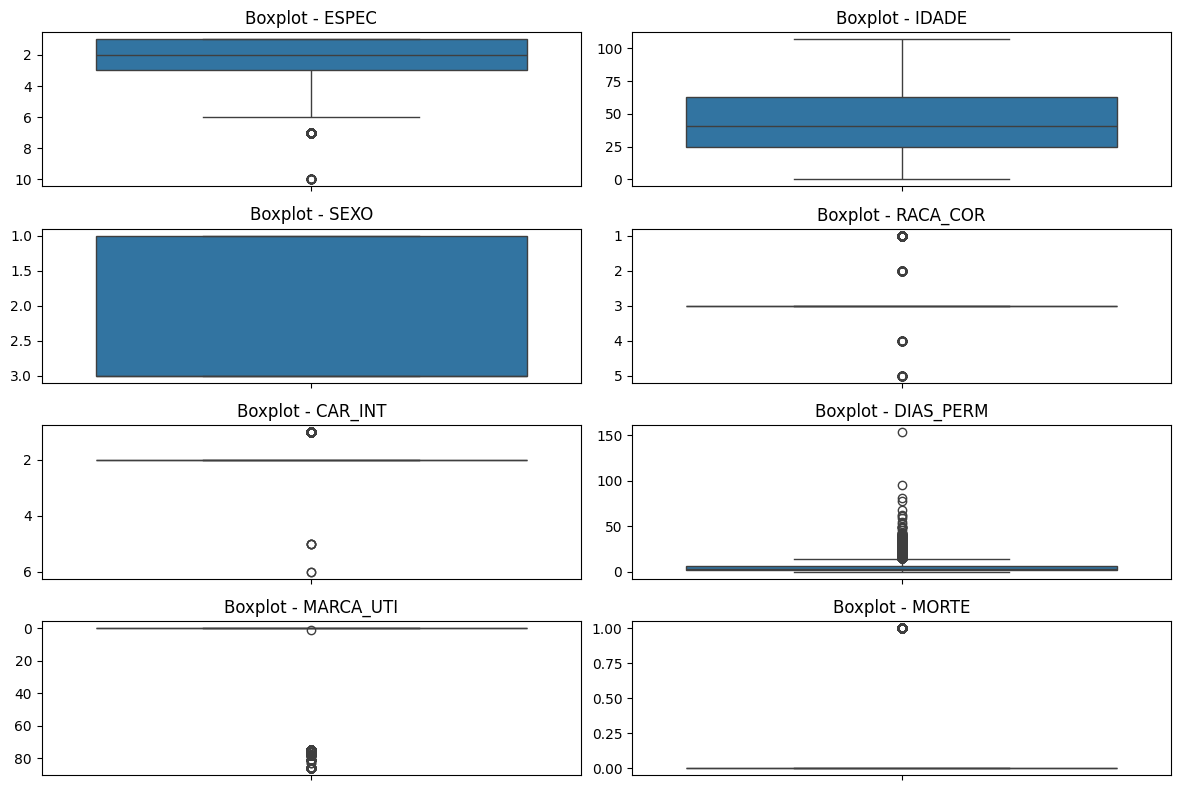

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(4, 2, figsize=(12, 8))
axes = axes.flatten()

for idx, col in enumerate(["ESPEC", "IDADE", "SEXO", 'RACA_COR', "CAR_INT", "DIAS_PERM", "MARCA_UTI", "MORTE"]):
    sns.boxplot(y=df_pb_filtrado[col], ax=axes[idx])
    axes[idx].set_title(f'Boxplot - {col}')
    # remover apenas o texto do rótulo Y
    axes[idx].set_ylabel('')

plt.tight_layout()
plt.show()

Os boxplots apresentados fornecem uma visão geral da distribuição das variáveis selecionadas no conjunto de dados filtrado. Abaixo, segue uma análise geral para cada variável:

1. **ESPEC (Especialidade)**: O boxplot mostra a distribuição das especialidades médicas. Como é uma variável categórica, os valores representam diferentes categorias de especialidades. A altura das caixas indica a frequência relativa de cada categoria.

2. **IDADE**: O boxplot da idade apresenta a distribuição etária dos pacientes. A mediana (linha central da caixa) indica a idade mediana, enquanto os quartis mostram a dispersão dos dados. Valores atípicos (outliers) podem ser observados como pontos fora dos limites do boxplot, indicando pacientes com idades muito altas ou muito baixas.

3. **SEXO**: Sendo uma variável categórica, o boxplot do sexo reflete a distribuição entre os gêneros. As categorias podem representar masculino e feminino, e a altura das caixas indica a frequência relativa de cada gênero.

4. **RACA_COR (Raça/Cor)**: Este boxplot apresenta a distribuição das categorias de raça/cor. A maioria dos registros parece estar concentrada em uma ou duas categorias, indicando predominância de determinados grupos raciais.

5. **CAR_INT (Características de Internação)**: O boxplot desta variável categórica mostra a distribuição das características de internação, como gravidade ou tipo de atendimento. A altura das caixas reflete a frequência relativa de cada categoria.

6. **DIAS_PERM (Dias de Permanência)**: O boxplot dos dias de permanência hospitalar mostra a variação no tempo de internação dos pacientes. A mediana e os quartis indicam a tendência central e a dispersão, enquanto os outliers podem indicar internações excepcionalmente longas.

7. **MARCA_UTI (Marca de UTI)**: Este boxplot reflete a distribuição das categorias relacionadas ao uso de UTI. A maioria dos registros parece estar concentrada em uma categoria específica, indicando que a maioria dos pacientes não utilizou UTI.

8. **MORTE**: O boxplot da variável morte, sendo binária, mostra a distribuição entre pacientes que sobreviveram e aqueles que faleceram. A altura das caixas reflete a frequência relativa de cada categoria.

### Relações lineares entre variáveis numéricas
 A matriz de correlação de Spearman entre as variáveis numéricas do dataset. O objetivo é identificar relações lineares fortes que possam informar próximas etapas (e.g., seleção de variáveis, multicolinearidade, ou insights de causa/efeito possível).

Pontos importantes:
- O coeficiente de Pearson varia de -1 a 1; 1 indica correlação positiva perfeita, -1 correlação negativa perfeita, e 0 nenhuma correlação linear.
- Correlação não implica causalidade: use estes resultados apenas como sinalizadores.
- Atenção a colinearidade: variáveis fortemente correlacionadas podem distorcer modelos que supõem independência entre variáveis (e.g., regressão).

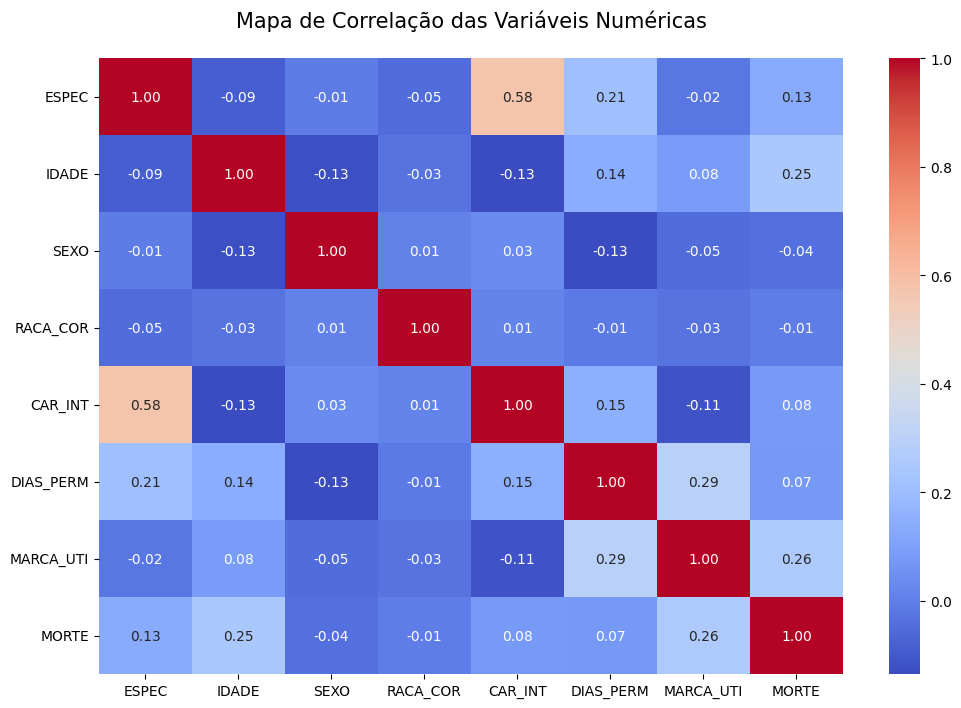

In [18]:
from scipy.stats import pearsonr

# # # Gráfico de correlação entre todas as variáveis numéricas do DataFrame dados_titanic1
# plt.figure(figsize=(12,8))
# corr = df_pb_filtrado.corr(numeric_only=False, method = "spearman")
# sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
# plt.title('matrix de correlações entre variáveis numéricas')
# # calcular p-values de Pearson para cada par de variáveis
# cols = corr.columns.tolist()
# pvals = pd.DataFrame(np.nan, index=cols, columns=cols)

# for i in range(len(cols)):
#     for j in range(len(cols)):
#         x = df_pb_filtrado[cols[i]]
#         y = df_pb_filtrado[cols[j]]
#         mask = x.notna() & y.notna()
#         if mask.sum() > 2:
#             _, p = spearmanr(x[mask], y[mask])
#         else:
#             p = np.nan
#         pvals.iloc[i, j] = p

# # função para transformar p-value em estrelas de significância
# def sig_stars(p):
#     if pd.isna(p):
#         return ''
#     if p < 0.001:
#         return '***'
#     if p < 0.01:
#         return '**'
#     if p < 0.05:
#         return '*'
#     return ''

# # anotar estrelas de significância sobre o heatmap
# ax = plt.gca()
# n = len(cols)
# for i in range(n):
#     for j in range(n):
#         star = sig_stars(pvals.iloc[i, j])
#         if star:
#             # posicionar a estrela levemente acima do número da correlação
#             ax.text(j + 0.5, i + 0.28, star, ha='center', va='center', color='black', fontsize=14)

# plt.show()



# Iremos dropar (retirar) a coluna ID, pois ela não é relevante para a análise de correlação
df_pb_filtrado.corr("spearman")

# # Heatmap# p
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('matrix de correlações entre variáveis numéricas')
plt.title("Mapa de Correlação das Variáveis Numéricas\n", fontsize = 15)
plt.show()

Diante das variáveis selecionadas, optou-se por prosseguir as análises sem a variável **ESPEC**, uma vez que ela se encontra fortemente correlacionada com **CAR_INT**. Considerando essa elevada correlação, manteve-se no modelo apenas as demais variáveis, a fim de evitar problemas de multicolinearidade e possíveis distorções nas estimativas.

In [ ]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# import pandas as pd

# X = df_pb_filtrado.drop(columns=['MORTE'])  # remove a variável dependente
# # Calcular VIF para cada variável
# vif_data = pd.DataFrame()
# vif_data["Variável"] = X.columns
# vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# print(vif_data)


In [74]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

#df_pb_filtrado["MORTE"] = df_pb_filtrado["MORTE"].astype(int)
#print(df_pb_filtrado["MORTE"].value_counts())

logit = smf.logit(
    formula=" MORTE ~ IDADE + C(SEXO) + DIAS_PERM + C(CAR_INT)",
    data=df_pb_filtrado,
).fit(maxiter=100000)  # ← aumentar de 35 para 100

logit.summary()
#resumo = logit.summary(xname=["intercepto", "Classe femínina", "Idade"]); resumo
#resumo.as_latex_tabular()
#logit.mle_retvals


Optimization terminated successfully.
         Current function value: 0.183816
         Iterations 2416


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  MORTE   No. Observations:                10692
Model:                          Logit   Df Residuals:                    10685
Method:                           MLE   Df Model:                            6
Date:                sex, 13 fev 2026   Pseudo R-squ.:                  0.1813
Time:                        14:08:07   Log-Likelihood:                -1965.4
converged:                       True   LL-Null:                       -2400.5
Covariance Type:            nonrobust   LLR p-value:                1.030e-184
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -6.7093      0.206    -32.606      0.000      -7.113      -6.306
C(SEXO)[T.3]         -0.1489      0.087     -1.716      0.086      -0.319       0.021
C(CAR_INT)[T.2.0]     1.2766      0.150      8.483      0.000       0.982       1.572
C(CAR_INT)[T.5.0]   -34.5322   2.07e+08  -1.67e-07      1.000   -4.06e+08    4.06e+08
C(CAR_INT)[T.6.0]   -75.8771   2.06e+17  -3.68e-16      1.000   -4.05e+17    4.05e+17
IDADE                 0.0496      0.002     23.301      0.000       0.045       0.054
DIAS_PERM             0.0260      0.005      5.148      0.000       0.016       0.036
=====================================================================================
"""

In [75]:
#logit.params
from matplotlib.pylab import exp #ou
import numpy as np
exp(logit.conf_int(alpha=0.05)).round(3)


C:\Users\fabia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\internals\blocks.py:395: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


,0,1
Intercept,0.001,0.002
C(SEXO)[T.3],0.727,1.021
C(CAR_INT)[T.2.0],2.669,4.814
C(CAR_INT)[T.5.0],0.000,inf
C(CAR_INT)[T.6.0],0.000,inf
IDADE,1.046,1.055
DIAS_PERM,1.016,1.037


In [76]:
np.exp(logit.params). round(3)

Intercept            0.001
C(SEXO)[T.3]         0.862
C(CAR_INT)[T.2.0]    3.584
C(CAR_INT)[T.5.0]    0.000
C(CAR_INT)[T.6.0]    0.000
IDADE                1.051
DIAS_PERM            1.026
dtype: float64

### Por que utilizar a função `exp` para interpretar os intervalos de confiança?

No modelo de regressão logística, os coeficientes estimados (coef) estão na escala de log-odds (logaritmo das chances). Essa escala não é diretamente interpretável em termos de probabilidades ou razões de chances (odds ratio). Para interpretar os coeficientes de forma mais intuitiva, é necessário transformá-los de volta para a escala de odds, o que é feito aplicando a função exponencial (`exp`).

- Aplicando a função `exp`, temos:
    - `exp(0.0513) ≈ 1.0513`
    - `exp(-0.1353) ≈ 0.873`
- O odds ratio para **IDADE** é 1.0513, com um intervalo de confiança de [1.048, 1.057]. Isso significa que, para cada ano adicional de idade, a chance de óbito aumenta em aproximadamente 5.13%, com o aumento variando entre 4.8% e 5.7% com 95% de confiança.
- O odds ratio para **SEXO** é 0.873, com um intervalo de confiança de [0.738, 1.033]. Isso significa que, em relação a categoria de base (sexo masculino), a chance de óbito diminui em aproximadamente 12,7%, variando entre 2.62% e 3.33% com 95% de confiança.


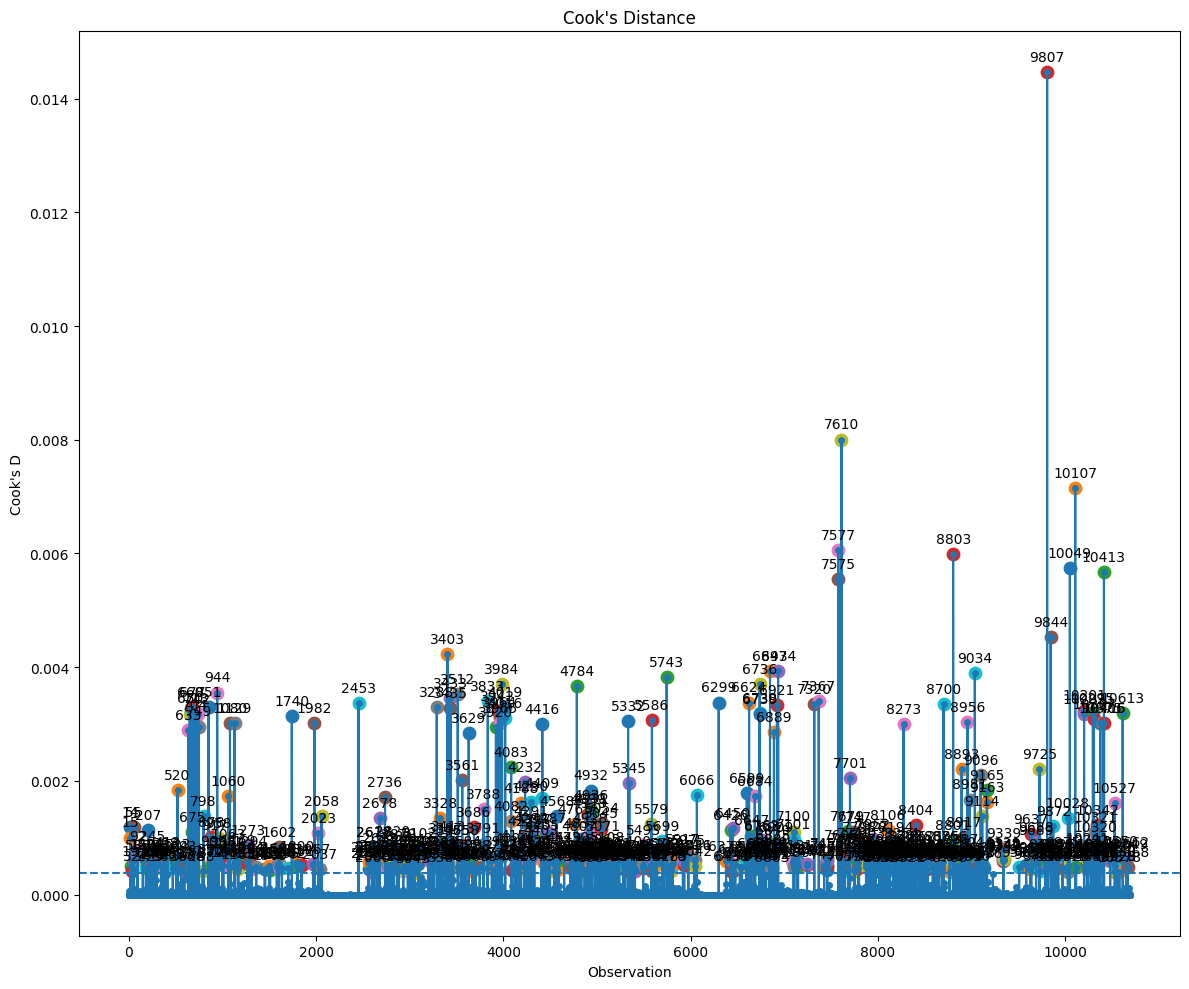

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Dados
y = logit.model.endog
p = logit.predict()

# Evita problemas numéricos
p = np.clip(p, 1e-8, 1 - 1e-8)

# Pearson residuals
resid_pearson = (y - p) / np.sqrt(p * (1 - p))

# Deviance residuals
resid_deviance = np.sign(y - p) * np.sqrt(
    -2 * (y * np.log(p) + (1 - y) * np.log(1 - p))
)

# Influência
influence = logit.get_influence()
hat_values = influence.hat_matrix_diag
cooks_d = influence.cooks_distance[0]

# ===========================
# Painel 2x2
# ===========================

#fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# # 1️⃣ Deviance residuals
# ax[0, 0].scatter(p, resid_deviance)
# ax[0, 0].axhline(0, linestyle='--')
# ax[0, 0].set_title("Deviance Residuals vs Fitted")
# ax[0, 0].set_xlabel("Fitted probabilities")
# ax[0, 0].set_ylabel("Deviance residuals")

# # 2️⃣ Pearson residuals
# ax[0, 1].scatter(p, resid_pearson)
# ax[0, 1].axhline(0, linestyle='--')
# ax[0, 1].set_title("Pearson Residuals vs Fitted")
# ax[0, 1].set_xlabel("Fitted probabilities")
# ax[0, 1].set_ylabel("Pearson residuals")

# # 3️⃣ Leverage
# ax[1, 0].scatter(p, hat_values)
# ax[1, 0].set_title("Leverage vs Fitted")
# ax[1, 0].set_xlabel("Fitted probabilities")
# ax[1, 0].set_ylabel("Leverage")

# 4️⃣ Cook’s Distance
fig, ax = plt.subplots(1, figsize=(12, 10))
n = len(y)
threshold = 4 / n

influential_points = np.where(cooks_d > threshold)[0]

plt.plot(cooks_d, linestyle='-', marker='o', markersize=4)
plt.axhline(threshold, linestyle='--')

for i in influential_points:
    plt.scatter(i, cooks_d[i], s=80)
    plt.annotate(
        str(i),
        (i, cooks_d[i]),
        textcoords="offset points",
        xytext=(0,8),
        ha='center'
    )

plt.title("Cook's Distance")
plt.xlabel("Observation")
plt.ylabel("Cook's D")
plt.tight_layout()
plt.show()


In [79]:

influence = logit.get_influence()
cooks_d = influence.cooks_distance[0]
hat_values = influence.hat_matrix_diag

resid_deviance = np.sign(y - p) * np.sqrt(
    -2 * (y * np.log(p) + (1 - y) * np.log(1 - p))
)

n = len(y)
k = logit.df_model  # número de preditores

# Critérios
cook_cut = 4 / n
lev_cut = 2 * (k + 1) / n

idx_cook = np.where(cooks_d > cook_cut)[0]
idx_lev = np.where(hat_values > lev_cut)[0]
idx_res = np.where(np.abs(resid_deviance) > 2)[0]

# União dos índices problemáticos
idx_problem = np.unique(
    np.concatenate([idx_cook, idx_lev, idx_res])
)

print("Total de observações conflitantes:", len(idx_problem))


Total de observações conflitantes: 1132


In [80]:
df_clean = df_pb_filtrado.drop(index=[9807,7610,10107,8803, 10049,10413,9034, 10048, 10108, 10050, 10051, 10052, 10053, 10054, 10055, 10056, 10057, 10058, 10059, 10060])
df_clean.describe()

logit1 = smf.logit(
    formula="MORTE ~ IDADE + C(SEXO) + DIAS_PERM + C(CAR_INT)",
    data=df_clean,
).fit(maxiter=100000)
logit1.summary()

         Current function value: 0.182343
         Iterations: 100000


C:\Users\fabia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  MORTE   No. Observations:                10672
Model:                          Logit   Df Residuals:                    10665
Method:                           MLE   Df Model:                            6
Date:                sex, 13 fev 2026   Pseudo R-squ.:                  0.1842
Time:                        14:12:43   Log-Likelihood:                -1946.0
converged:                      False   LL-Null:                       -2385.4
Covariance Type:            nonrobust   LLR p-value:                1.387e-186
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -6.7897      0.209    -32.415      0.000      -7.200      -6.379
C(SEXO)[T.3]         -0.1566      0.087     -1.796      0.073      -0.328       0.014
C(CAR_INT)[T.2.0]     1.3269      0.155      8.587      0.000       1.024       1.630
C(CAR_INT)[T.5.0]   -34.3792   2.01e+08  -1.71e-07      1.000   -3.93e+08    3.93e+08
C(CAR_INT)[T.6.0]   -21.1300   2.74e+05   -7.7e-05      1.000   -5.38e+05    5.38e+05
IDADE                 0.0502      0.002     23.370      0.000       0.046       0.054
DIAS_PERM             0.0245      0.006      4.391      0.000       0.014       0.035
=====================================================================================
"""